In [6]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
from functools import partial

import sys, os
sys.path.append(os.path.join(os.getcwd(), "../"))
from src.data.data_reader import DataReader

In [7]:
#makes dummy data

def ode_dynamics(t, y, args):
    return -0.1 * y + t / 10

def generate_latent_process(ts, xs, initial_latent=1.0):
    latent = initial_latent
    latent_values = []
    for i in range(len(ts)):
        if i > 0:
            sol = diffrax.diffeqsolve(
                diffrax.ODETerm(ode_dynamics),
                diffrax.Tsit5(),
                t0=ts[i-1],
                t1=ts[i],
                dt0=0.01,
                y0=latent
            )
            latent = sol.ys[-1]
        latent += 0.1 * jnp.sum(xs[i])
        latent_values.append(latent)
    return jnp.array(latent_values)

def get_data(num_sequences=100, sequence_length=50, test_ratio=0.2, key=None, x_size=2):
    train_data = []
    for _ in range(num_sequences):
        key, subkey = jr.split(key)
        ts = jr.uniform(subkey, shape=(sequence_length,), minval=0, maxval=10)
        ts_test = jr.uniform(subkey, shape=(int(sequence_length * test_ratio),), minval=0, maxval=10)
        ts = jnp.sort(ts)
        ts_test = jnp.sort(ts_test)
        
        xs = jr.normal(subkey, shape=(sequence_length, x_size))  
        latent_values = generate_latent_process(ts, xs[:, :]) 
        y_test = latent_values[jnp.searchsorted(ts, ts_test)] + jr.normal(subkey, shape=(len(ts_test),)) * 0.1
        
        train_data.append((ts, xs, ts_test, y_test))
    
    return train_data

def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while start < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


In [8]:
#Func is for the differential equation 

class Func(eqx.Module):
    mlp: eqx.nn.MLP  
    
    def __init__(self, mlp):
        self.mlp = mlp

    def __call__(self, t, y, args):
        return self.mlp(y) 
    
#Latent ODE model

class NeuralODEModel(eqx.Module):
    func: Func
    rnn_cell: eqx.nn.GRUCell
    latent_to_y: eqx.nn.MLP
    latent_size: int
    x_proj: eqx.nn.Linear  

    def __init__(self, func, rnn_cell, latent_to_y, latent_size, x_size):
        self.func = func
        self.rnn_cell = rnn_cell
        self.latent_to_y = latent_to_y
        self.x_proj = eqx.nn.Linear(x_size, latent_size, key=jax.random.PRNGKey(7))  
        
        self.latent_size = latent_size

    def _propagate_ode(self, latent, t0, t1):
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=t0,
            t1=t1,
            dt0=0.1,
            y0=latent,
        )
        return sol.ys[-1]

    def predict(self, ts, xs, ts_test):
        latent = jnp.zeros((ts.shape[0], self.latent_size))  
        ts_combined = jnp.sort(jnp.concatenate([ts, ts_test], axis=1))  
        ys_pred = jnp.zeros((ts_test.shape[0], ts_test.shape[1], 1)) 

        test_index = 0

        for i in range(1, ts_combined.shape[1]):
            t0, t1 = ts_combined[:, i-1], ts_combined[:, i]
            latent = jax.vmap(self._propagate_ode)(latent, t0, t1) 

            latent = lax.cond(
                jnp.any(jnp.isin(t1, ts[:, :ts.shape[1]])),
                lambda lt: jax.vmap(lambda lt, x_lat: self.rnn_cell(lt, x_lat))(lt, jax.vmap(self.x_proj)(xs[:, i-1, :])),
                lambda lt: lt,
                latent
            )


            def update_prediction(yp, latent):
                y_pred = jax.vmap(self.latent_to_y)(latent)
                return yp.at[:, test_index, 0].set(y_pred.squeeze())

            ys_pred = lax.cond(
                jnp.any(jnp.isin(t1, ts_test)),
                lambda yp: update_prediction(yp, latent),
                lambda yp: yp,
                ys_pred
            )
            
            test_index = lax.cond(
                jnp.any(jnp.isin(t1, ts_test)),
                lambda idx: idx + 1,
                lambda idx: idx,
                test_index
            )

        return ys_pred.squeeze()

    def compute_loss(self, ts, xs, ts_test, y_true):
        y_pred = self.predict(ts, xs, ts_test) 
        return self.loss(y_pred, y_true)

    @staticmethod
    def loss(y_pred, y_true):
        return jnp.mean((y_pred - y_true) ** 2)

In [9]:
def train(model, train_data, optimizer, steps, batch_size, seq_length, key):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    
    @eqx.filter_value_and_grad
    def loss(model, ts, xs, ts_test, y_true):
        return model.compute_loss(ts, xs, ts_test, y_true)

    @eqx.filter_jit
    def make_step(model, opt_state, ts, xs, ts_test, y_true):
        value, grads = loss(model, ts, xs, ts_test, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state

    for step in range(steps):
        print(step)
        for idx in range(0, len(train_data), batch_size):
            batch = train_data[idx:idx + batch_size]
            ts_batch = jnp.stack([data[0] for data in batch])  
            xs_batch = jnp.stack([data[1] for data in batch])  
            ts_test_batch = jnp.stack([data[2] for data in batch])  
            y_true_batch = jnp.stack([data[3] for data in batch])  

            loss_value, model, opt_state = make_step(model, opt_state, ts_batch, xs_batch, ts_test_batch, y_true_batch)

            if step % 1 == 0 and idx == 0:  
                print(f"Step {step}, Loss: {loss_value:.4f}")

    return model

In [10]:
batch_size = 8
train_steps = 10000
latent_size = 2
x_size = 3 
eta = 3e-3
pred_mlp_width = 4
pred_mlp_depth = 2
num_train_seq = 64
train_seq_len = 32
train_test_ratio = 0.25 #note: This is the ratio of ys to (xs + ys) in the training set, not the train-test split ratio
func_mlp_width = 4
func_mlp_depth = 2

mlp_key = jax.random.PRNGKey(3)
mlp = eqx.nn.MLP(in_size=latent_size, out_size=latent_size, width_size=func_mlp_width, depth=func_mlp_depth, key=mlp_key)  
func = Func(mlp=mlp) 

rnn_cell = eqx.nn.GRUCell(input_size=latent_size, hidden_size=latent_size, key=jax.random.PRNGKey(1))  
latent_to_y = eqx.nn.MLP(in_size=latent_size, out_size=1, width_size=pred_mlp_width, depth=pred_mlp_depth, key=jax.random.PRNGKey(2))

model = NeuralODEModel(func=func, rnn_cell=rnn_cell, latent_to_y=latent_to_y, latent_size=latent_size, x_size=x_size)

optimizer = optax.adam(learning_rate=eta)

train_data = get_data(num_sequences=num_train_seq, sequence_length=train_seq_len, test_ratio=train_test_ratio, key=jax.random.PRNGKey(10), x_size = x_size)
trained_model = train(model, train_data, optimizer, steps=train_steps, batch_size=batch_size, seq_length=train_seq_len, key=jax.random.PRNGKey(4))

0


2024-10-13 01:04:11.942782: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-10-13 01:05:02.727873: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m50.788682s

********************************
[Compiling module jit_make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Step 0, Loss: 5.1881
1
Step 1, Loss: 4.7709
2
Step 2, Loss: 4.4479
3
Step 3, Loss: 4.2075
4
Step 4, Loss: 4.0333
5
Step 5, Loss: 3.9085
6
Step 6, Loss: 3.8133
7
Step 7, Loss: 3.7315
8
Step 8, Loss: 3.6550
9
Step 9, Loss: 3.5826
10
Step 10, Loss: 3.5128
11
Step 11, Loss: 3.4444
12
Step 12, Loss: 3.3774
13
Step 13, Loss: 3.3118
14
Step 14, Loss: 3.2476
15
Step 15, Loss: 3.1846
16
Step 16, Loss: 3.1229
17
Step 17, Loss: 3.0625
18
Step 18, Loss: 3.0034
19
Step 19, Loss: 2.9455
20
Step 20, Loss: 2.8888
21
Step 21, Loss: 2.8334
22
Step 22, Loss: 2.7792
23
Step 23, Loss: 2.7262
24
Step 24, Loss: 2.6744
25
Step 25, Loss: 2.6239
26
Step 26, Loss: 2.5744
27
Step 27, Loss: 2.5262
28
Step 28, Loss: 2.4790
29
Step 29, Loss: 2.4331
30
Step 30, Loss: 2.3882
31
Step 31, Loss: 2.3444
32
Step 32, Loss: 2.3017
33
Step 33, Loss: 2.2601
34
Step 34, Loss: 2.2195
35
Step 35, Loss: 2.1799
36
Step 36, Loss: 2.1414
37
Step 37, Loss: 2.1039
38
Step 38, Loss: 2.0674
39
Step 39, Loss: 2.0318
40
Step 40, Loss: 1.99

In [11]:
n = 5
test_data = get_data(num_sequences=n, sequence_length=20, test_ratio=0.2, key=jax.random.PRNGKey(12),  x_size = x_size)

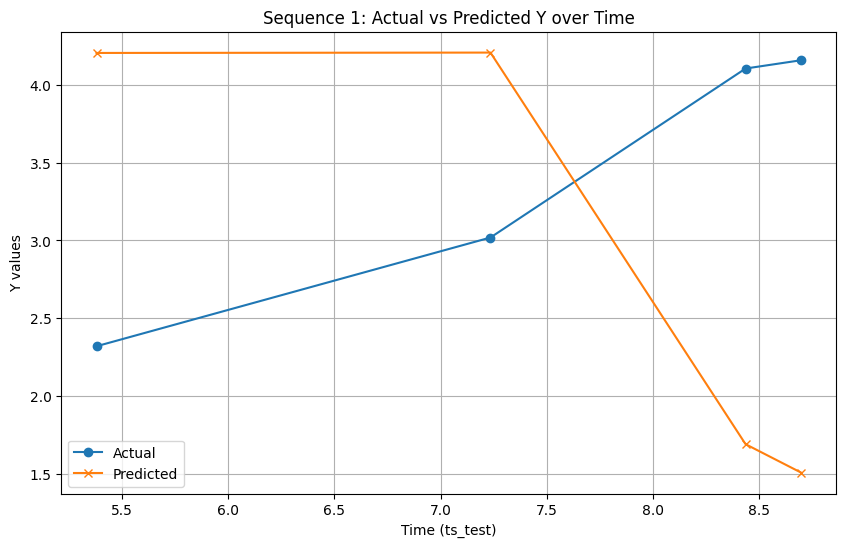

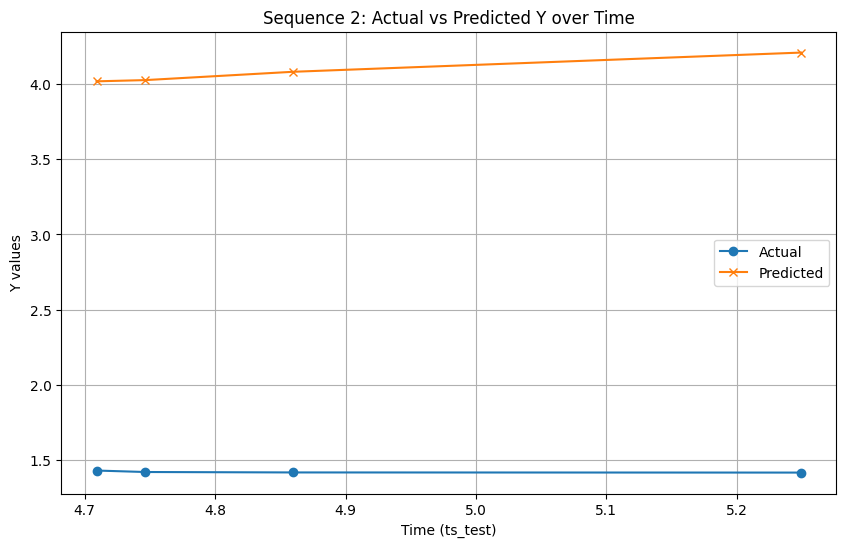

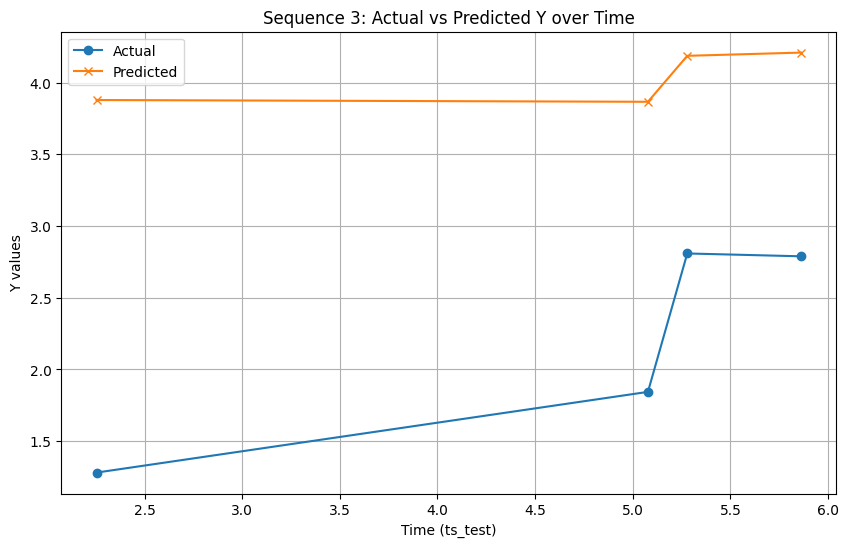

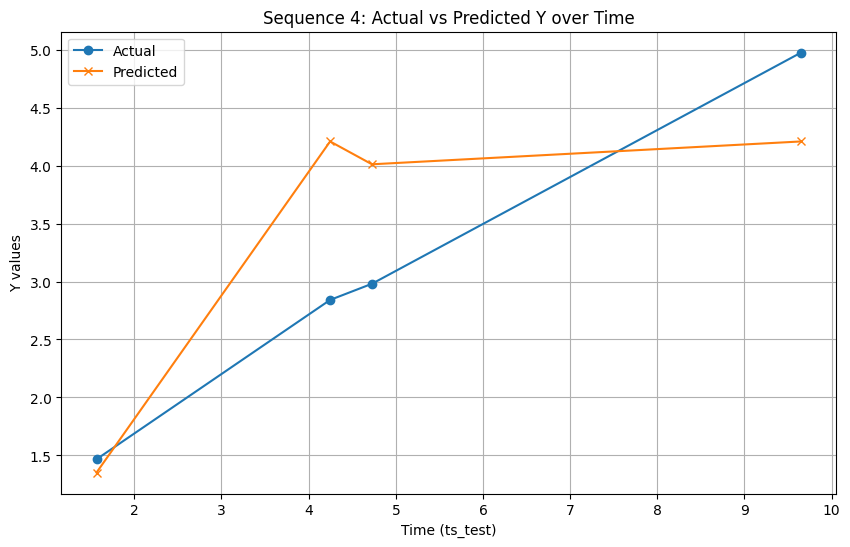

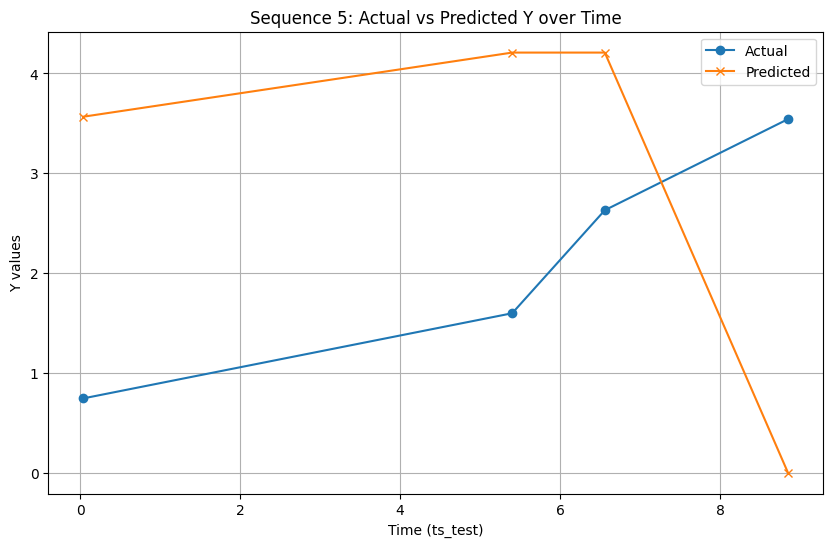

In [12]:

import matplotlib.pyplot as plt

for idx in range(n): 
    ts, xs, ts_test, y_true = test_data[idx]
    y_pred = trained_model.predict(jnp.expand_dims(ts, axis=0), jnp.expand_dims(xs, axis=0), jnp.expand_dims(ts_test, axis=0))
    y_pred = y_pred.squeeze()

    plt.figure(figsize=(10, 6))
    plt.plot(ts_test, y_true, label='Actual', marker='o')
    plt.plot(ts_test, y_pred, label='Predicted', marker='x')
    plt.xlabel('Time (ts_test)')
    plt.ylabel('Y values')
    plt.title(f'Sequence {idx + 1}: Actual vs Predicted Y over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
y_pred

Array([3.5661154, 4.208653 , 4.208653 , 0.       ], dtype=float32)